# Offside

## Description of the Reference Domain, and Objectives
The offside project starts from the idea of creating a recommendation system based on machine learning which, given a football player, returns a series of players as similar as possible to him based on a set of technical-tactical data. The reference domain is, obviously, the world of football, and the reference platform for data ingestion is Fbref, a consultation font that includes data relating to players, teams and championships

The solution approach that the project intends to adopt is based on a rather simple notion: let's assume we have a two-dimensional Cartesian plane, where each point corresponds to a player based on a pair of technical characteristics of our choice. The players most similar to the original player will be those who have the smallest distance on the Cartesian plane. It is sufficient to raise the plane to n dimensions, one for each of the technical attributes considered, to evaluate the similarity of the players on the hyperplane

## Description of the Data Retrieval Phase
The code snippet provided aims to retrieve data from a specific URL using Python. Initially, the `requests` library is imported, which is a powerful tool for making HTTP requests in Python. Next, the `pandas` library is imported as `pd`, which is extensively used for data manipulation and analysis.

The URL specified points to a webpage on FBref, a website that provides comprehensive football statistics and analysis. FBref is a well-known platform among football enthusiasts and analysts for its extensive coverage of various leagues, teams, and players worldwide.

Moving on to the code execution, the URL variable holds the address of the webpage containing Serie A statistics on FBref. The `pd.read_html()` function is then utilized to parse the HTML content of the webpage and extract tables. However, prior to parsing, the `.replace()` method is employed to remove HTML comment tags ('<!--' and '-->') from the webpage content. This is done to ensure that the HTML is clean and can be accurately parsed by `read_html()`.

Inside the `pd.read_html()` function call, the `requests.get(url).text` retrieves the HTML content of the specified URL, which is then passed to `read_html()` for parsing. The `attrs` parameter is utilized to specify the HTML attribute `id` of the table element to be extracted, which in this case is 'stats_standard'. The `[0]` index is appended to the end of the function call to select the first table found on the webpage matching the specified attributes.

Overall, the provided code fetches Serie A statistics data from FBref website, ensuring that HTML comments are removed to facilitate accurate parsing, and extracts the desired table for further processing using pandas.

In [234]:
import requests
import pandas as pd

url= 'https://fbref.com/en/comps/11/stats/Serie-A-Stats'
df = pd.read_html(
    requests.get(url).text.replace('<!--','').replace('-->','')
    ,attrs={'id':'stats_standard'}
)[0]

# Definisci i nomi delle colonne desiderati
new_columns = ["(Background Information, Alphabetical Rank)", 
               "(Background Information, Full Name)", 
               "(Background Information, Nation)", 
               "(Background Information, Position)", 
               "(Background Information, Squad)", 
               "(Background Information, Age)", 
               "(Background Information, Year of Birth)",
               "(Playing Time, MP)",
               "(Playing Time, Starts)",
               "(Playing Time, Min)",
               "(Playing Time, 90s)",
               "(Performance, Gls)",
               "(Performance, Ast)",
               "(Performance, G+A)",
               "(Performance, G-PK)",
               "(Performance, PK)",
               "(Performance, PKatt)",
               "(Performance, CrdY)",
               "(Performance, CrdR)",
               "(Expected, xG)",
               "(Expected, npxG)",
               "(Expected, xAG)",
               "(Expected, npxG+xAG)",
               "(Progression, PrgC)",
               "(Progression, PrgP)",
               "(Progression, PrgR)",
               "(Per 90 Minutes, Gls)",
               "(Per 90 Minutes, Ast)",
               "(Per 90 Minutes, G+A)",
               "(Per 90 Minutes, G-PK)",
               "(Per 90 Minutes, G+A-PK)",
               "(Per 90 Minutes, xG)",
               "(Per 90 Minutes, xAG)",
               "(Per 90 Minutes, xG+xAG)",
               "(Per 90 Minutes, npxG)",
               "(Per 90 Minutes, npxG+xAG)"] + list(df.columns[36:])


# Assegna i nuovi nomi delle colonne
df.columns = new_columns



df["(Background Information, Full Name)"] = df["(Background Information, Full Name)"].astype("string")
df["(Background Information, Position)"] = df["(Background Information, Position)"].astype("category")
df["(Background Information, Squad)"] = df["(Background Information, Squad)"].astype("category")
df["(Background Information, Year of Birth)"] = pd.to_numeric(df["(Background Information, Year of Birth)"], errors='coerce')
df["(Playing Time, MP)"] = pd.to_numeric(df["(Playing Time, MP)"], errors='coerce')
df["(Playing Time, Starts)"] = pd.to_numeric(df["(Playing Time, Starts)"], errors='coerce')
df["(Playing Time, Min)"] = pd.to_numeric(df["(Playing Time, Min)"], errors='coerce')
df["(Playing Time, 90s)"] = pd.to_numeric(df["(Playing Time, 90s)"], errors='coerce')
df["(Performance, Gls)"] = pd.to_numeric(df["(Performance, Gls)"], errors='coerce')
df["(Performance, Ast)"] = pd.to_numeric(df["(Performance, Ast)"], errors='coerce')
df["(Performance, G+A)"] = pd.to_numeric(df["(Performance, G+A)"], errors='coerce')
df["(Performance, G-PK)"] = pd.to_numeric(df["(Performance, G-PK)"], errors='coerce')
df["(Performance, PK)"] = pd.to_numeric(df["(Performance, PK)"], errors='coerce')
df["(Performance, PKatt)"] = pd.to_numeric(df["(Performance, PKatt)"], errors='coerce')
df["(Performance, CrdY)"] = pd.to_numeric(df["(Performance, CrdY)"], errors='coerce')
df["(Performance, CrdR)"] = pd.to_numeric(df["(Performance, CrdR)"], errors='coerce')
df["(Expected, xG)"] = pd.to_numeric(df["(Expected, xG)"], errors='coerce')
df["(Expected, npxG)"] = pd.to_numeric(df["(Expected, npxG)"], errors='coerce')
df["(Expected, xAG)"] = pd.to_numeric(df["(Expected, xAG)"], errors='coerce')
df["(Expected, npxG+xAG)"] = pd.to_numeric(df["(Expected, npxG+xAG)"], errors='coerce')
df["(Progression, PrgC)"] = pd.to_numeric(df["(Progression, PrgC)"], errors='coerce')
df["(Progression, PrgP)"] = pd.to_numeric(df["(Progression, PrgP)"], errors='coerce')
df["(Progression, PrgR)"] = pd.to_numeric(df["(Progression, PrgR)"], errors='coerce')
df["(Per 90 Minutes, Gls)"] = pd.to_numeric(df["(Per 90 Minutes, Gls)"], errors='coerce')
df["(Per 90 Minutes, Ast)"] = pd.to_numeric(df["(Per 90 Minutes, Ast)"], errors='coerce')
df["(Per 90 Minutes, G+A)"] = pd.to_numeric(df["(Per 90 Minutes, G+A)"], errors='coerce')
df["(Per 90 Minutes, G-PK)"] = pd.to_numeric(df["(Per 90 Minutes, G-PK)"], errors='coerce')
df["(Per 90 Minutes, G+A-PK)"] = pd.to_numeric(df["(Per 90 Minutes, G+A-PK)"], errors='coerce')
df["(Per 90 Minutes, xG)"] = pd.to_numeric(df["(Per 90 Minutes, xG)"], errors='coerce')
df["(Per 90 Minutes, xAG)"] = pd.to_numeric(df["(Per 90 Minutes, xAG)"], errors='coerce')
df["(Per 90 Minutes, xG+xAG)"] = pd.to_numeric(df["(Per 90 Minutes, xG+xAG)"], errors='coerce')
df["(Per 90 Minutes, npxG)"] = pd.to_numeric(df["(Per 90 Minutes, npxG)"], errors='coerce')
df["(Per 90 Minutes, npxG+xAG)"] = pd.to_numeric(df["(Per 90 Minutes, npxG+xAG)"], errors='coerce')

# Rimuovo le Informazioni Inutili
df.drop('(Background Information, Alphabetical Rank)', axis=1, inplace=True)
df.drop('(Background Information, Nation)', axis=1, inplace=True)
df.drop('(Background Information, Age)', axis=1, inplace=True)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)


df.to_csv("serieA.csv", encoding='utf-8', index=False)

df

,"(Background Information, Full Name)","(Background Information, Position)","(Background Information, Squad)","(Background Information, Year of Birth)","(Playing Time, MP)","(Playing Time, Starts)","(Playing Time, Min)","(Playing Time, 90s)","(Performance, Gls)","(Performance, Ast)",...,"(Per 90 Minutes, Gls)","(Per 90 Minutes, Ast)","(Per 90 Minutes, G+A)","(Per 90 Minutes, G-PK)","(Per 90 Minutes, G+A-PK)","(Per 90 Minutes, xG)","(Per 90 Minutes, xAG)","(Per 90 Minutes, xG+xAG)","(Per 90 Minutes, npxG)","(Per 90 Minutes, npxG+xAG)"
0,Francesco Acerbi,DF,Inter,1988.0,20.0,18.0,1642.0,18.2,2.0,1.0,...,0.11,0.05,0.16,0.11,0.16,0.06,0.09,0.15,0.06,0.15
1,Yacine Adli,MF,Milan,2000.0,16.0,12.0,994.0,11.0,1.0,0.0,...,0.09,0.00,0.09,0.09,0.09,0.03,0.04,0.07,0.03,0.07
2,Michel Aebischer,MF,Bologna,1997.0,25.0,17.0,1457.0,16.2,0.0,1.0,...,0.00,0.06,0.06,0.00,0.06,0.03,0.07,0.10,0.03,0.10
3,Lucien Agoume,MF,Inter,2002.0,1.0,0.0,5.0,0.1,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Marley Aké,FW,Udinese,2001.0,1.0,0.0,10.0,0.1,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,Nadir Zortea,DF,Atalanta,1999.0,5.0,0.0,149.0,1.7,1.0,0.0,...,0.60,0.00,0.60,0.60,0.60,0.05,0.16,0.21,0.05,0.21
606,Szymon Żurkowski,MF,Empoli,1997.0,6.0,5.0,451.0,5.0,4.0,0.0,...,0.80,0.00,0.80,0.80,0.80,0.14,0.02,0.16,0.14,0.16
607,Milan Đurić,FW,Hellas Verona,1990.0,20.0,13.0,1204.0,13.4,5.0,1.0,...,0.37,0.07,0.45,0.30,0.37,0.34,0.09,0.43,0.16,0.25
608,Milan Đurić,FW,Monza,1990.0,5.0,3.0,307.0,3.4,0.0,1.0,...,0.00,0.29,0.29,0.00,0.29,0.15,0.17,0.33,0.15,0.33


# Dataset Columns Explanation

This dataset comprises of several columns, each providing distinct information related to player performance and background details. The columns are detailed below:

## Background Information
1. **(Background Information, Alphabetical Rank)**: Represents the alphabetical ranking of the players.
2. **(Background Information, Full Name)**: Indicates the full name of the player.
3. **(Background Information, Nation)**: Specifies the nationality of the player.
4. **(Background Information, Position)**: Specifies the primary position of the player.
5. **(Background Information, Squad)**: Denotes the squad the player belongs to.
6. **(Background Information, Age)**: Represents the age of the player.
7. **(Background Information, Year of Birth)**: Indicates the year of birth of the player.

## Playing Time
8. **(Playing Time, MP)**: Stands for Matches Played.
9. **(Playing Time, Starts)**: Denotes the number of matches started by the player.
10. **(Playing Time, Min)**: Represents the total minutes played by the player.
11. **(Playing Time, 90s)**: Indicates the total minutes played divided by 90.

## Performance
12. **(Performance, Gls)**: Represents the number of goals scored by the player.
13. **(Performance, Ast)**: Denotes the number of assists made by the player.
14. **(Performance, G+A)**: Indicates the total number of goals and assists combined.
15. **(Performance, G-PK)**: Represents the number of goals scored excluding penalty kicks.
16. **(Performance, PK)**: Denotes the number of penalty kicks scored by the player.
17. **(Performance, PKatt)**: Represents the number of penalty kicks attempted by the player.
18. **(Performance, CrdY)**: Indicates the number of yellow cards received by the player.
19. **(Performance, CrdR)**: Denotes the number of red cards received by the player.

## Expected
20. **(Expected, xG)**: Represents the expected goals for the player.
21. **(Expected, npxG)**: Denotes the non-penalty expected goals for the player.
22. **(Expected, xAG)**: Represents the expected assists for the player.
23. **(Expected, npxG+xAG)**: Indicates the sum of non-penalty expected goals and expected assists.

## Progression
24. **(Progression, PrgC)**: Stands for progressive carries made by the player.
25. **(Progression, PrgP)**: Denotes progressive passes made by the player.
26. **(Progression, PrgR)**: Represents progressive carries made by the player.

## Per 90 Minutes
27. **(Per 90 Minutes, Gls)**: Represents the average number of goals scored per 90 minutes.
28. **(Per 90 Minutes, Ast)**: Denotes the average number of assists made per 90 minutes.
29. **(Per 90 Minutes, G+A)**: Indicates the average number of goals and assists combined per 90 minutes.
30. **(Per 90 Minutes, G-PK)**: Represents the average number of goals scored excluding penalty kicks per 90 minutes.
31. **(Per 90 Minutes, G+A-PK)**: Denotes the average number of goals and assists combined excluding penalty kicks per 90 minutes.
32. **(Per 90 Minutes, xG)**: Represents the average expected goals per 90 minutes.
33. **(Per 90 Minutes, xAG)**: Denotes the average expected assists per 90 minutes.
34. **(Per 90 Minutes, xG+xAG)**: Indicates the average sum of expected goals and expected assists per 90 minutes.
35. **(Per 90 Minutes, npxG)**: Represents the average non-penalty expected goals per 90 minutes.
36. **(Per 90 Minutes, npxG+xAG)**: Denotes the average sum of non-penalty expected goals and expected assists per 90 minutes.

These columns collectively provide a comprehensive overview of player performance, background, and progression metrics, facilitating in-depth analysis and insights.


In [226]:
import pandas as pd
from scipy.spatial.distance import euclidean

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Assume df è il tuo DataFrame contenente i dati dei calciatori

df.dropna(inplace=True)
relevant_cols = ["(Background Information, Position)", 
               "(Background Information, Year of Birth)",
               "(Playing Time, MP)",
               "(Playing Time, Starts)",
               "(Playing Time, Min)",
               "(Playing Time, 90s)",
               "(Performance, Gls)",
               "(Performance, Ast)",
               "(Performance, G+A)",
               "(Performance, G-PK)",
               "(Performance, PK)",
               "(Performance, PKatt)",
               "(Performance, CrdY)",
               "(Performance, CrdR)",
               "(Expected, xG)",
               "(Expected, npxG)",
               "(Expected, xAG)",
               "(Expected, npxG+xAG)",
               "(Progression, PrgC)",
               "(Progression, PrgP)",
               "(Progression, PrgR)",
               "(Per 90 Minutes, Gls)",
               "(Per 90 Minutes, Ast)",
               "(Per 90 Minutes, G+A)",
               "(Per 90 Minutes, G-PK)",
               "(Per 90 Minutes, G+A-PK)",
               "(Per 90 Minutes, xG)",
               "(Per 90 Minutes, xAG)",
               "(Per 90 Minutes, xG+xAG)",
               "(Per 90 Minutes, npxG)",
               "(Per 90 Minutes, npxG+xAG)"]  # Definisci le colonne rilevanti

numeric_cols = df[relevant_cols].select_dtypes(include=['number'])

# Normalizza i dati
normalized_df = (numeric_cols - numeric_cols.mean()) / numeric_cols.std()

# Specifica il nome del giocatore di riferimento
reference_player_name = "Victor Osimhen"

# Specifica il ruolo per il filtro
role_filter = None # Puoi cambiare il ruolo qui, leave None for no role selection

# Trova l'indice della riga corrispondente al giocatore di riferimento
reference_player_index = df.index[df['(Background Information, Full Name)'] == reference_player_name][0]

distances = {}
reference_player = normalized_df.loc[reference_player_index]

for i, player in normalized_df.iterrows():
    if i == reference_player_index:
        continue
    # Aggiungi condizione di filtro per il ruolo
    if role_filter is not None and df.loc[i]['(Background Information, Position)'] != role_filter:
        continue
    distances[i] = euclidean(reference_player, player)

sorted_distances = sorted(distances.items(), key=lambda x: x[1])

top_similar_players = sorted_distances[:5]


    
print(color.BOLD + f"The reference player is {reference_player_name}\n"
      f"Below is a list of the players most similar to the player mentioned above,\n"
      f"ordered from most to least similar via Euclidean distance sampling.\n" + color.END)
index_number = 1


if role_filter is not None:
    print(color.BOLD + f"Please note that the values returned by the model are filtered for the '{role_filter}' role. You can change or remove the filter entirely in the algorithm configuration section at any time\n" + color.END)
else:
    print(color.BOLD + "Please note that the values returned by the model are not filtered by any role. You can add or change the role filter in the algorithm configuration section at any time\n"  + color.END)
      
print('─' * 25)
print()


for player_index, distance in top_similar_players:
    player_name = df.loc[player_index]['(Background Information, Full Name)']
    player_role = df.loc[player_index]['(Background Information, Position)']
    player_club = df.loc[player_index]['(Background Information, Squad)']
    player_age = df.loc[player_index]['(Background Information, Year of Birth)']
    
    print(color.BOLD + f"Player #{index_number}: {player_name + color.END}\nRole: {player_role}\nTeam: {player_club}\nBorn In: {'{:.0f}'.format(player_age)}\nDelta: {'{:.5f}'.format(distance)}\n")
    
    index_number += 1


The reference player is Victor Osimhen
Below is a list of the players most similar to the player mentioned above,
ordered from most to least similar via Euclidean distance sampling.

Please note that the values returned by the model are not filtered by any role. You can add or change the role filter in the algorithm configuration section at any time

─────────────────────────

Player #1: Riccardo Orsolini
Role: FW,MF
Team: Bologna
Born In: 1997
Delta: 6.04832

Player #2: Dušan Vlahović
Role: FW
Team: Juventus
Born In: 2000
Delta: 6.32513

Player #3: Romelu Lukaku
Role: FW
Team: Roma
Born In: 1993
Delta: 6.54769

Player #4: Nicolás González
Role: FW
Team: Fiorentina
Born In: 1998
Delta: 6.75067

Player #5: Joshua Zirkzee
Role: FW
Team: Bologna
Born In: 2001
Delta: 7.12675


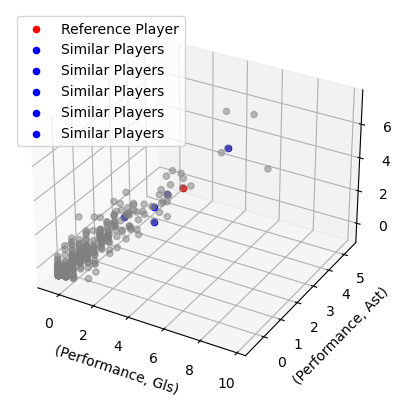

In [227]:

# Seleziona gli attributi per la visualizzazione tridimensionale
plot_attributes = ['(Performance, Gls)', '(Performance, Ast)', '(Expected, xG)']

# Prepara i dati per il plotting
player_data = normalized_df.loc[:, plot_attributes].values
reference_player_data = reference_player[plot_attributes].values

# Plot tridimensionale
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot di tutti i giocatori in grigio
ax.scatter(player_data[:,0], player_data[:,1], player_data[:,2], c='grey', alpha=0.5)

# Plot del giocatore di riferimento in rosso
ax.scatter(reference_player_data[0], reference_player_data[1], reference_player_data[2], c='red', label='Reference Player')

# Plot dei giocatori simili in blu
for player_index, _ in top_similar_players:
    player_data = normalized_df.loc[player_index, plot_attributes].values
    ax.scatter(player_data[0], player_data[1], player_data[2], c='blue', label='Similar Players')

ax.set_xlabel(plot_attributes[0])
ax.set_ylabel(plot_attributes[1])
ax.set_zlabel(plot_attributes[2])

plt.legend()
plt.show()



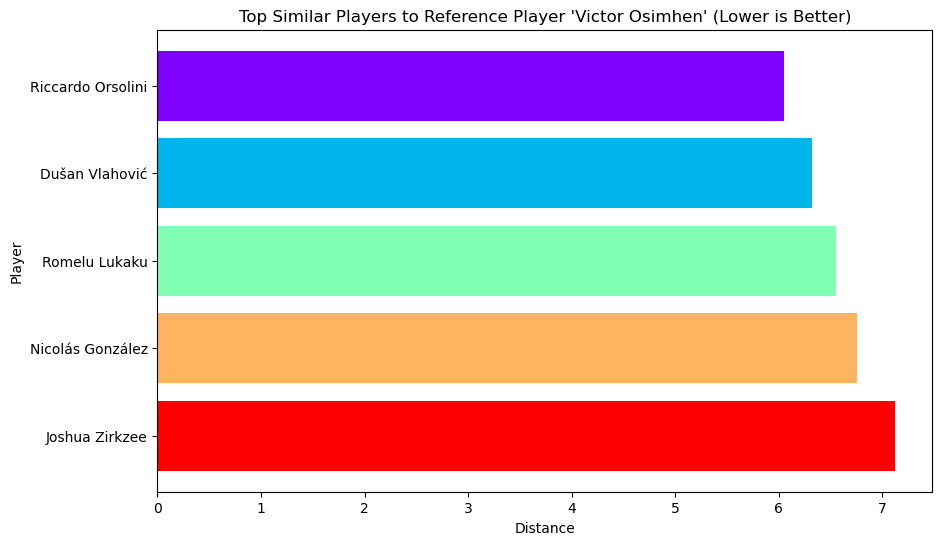

In [228]:
import matplotlib.pyplot as plt
import numpy as np

# Estrai i nomi e le distanze dei giocatori più simili
similar_player_names = [df.loc[player_index]['(Background Information, Full Name)'] for player_index, _ in top_similar_players]
similar_player_distances = [distance for _, distance in top_similar_players]

# Definisci i colori in ordine dell'arcobaleno
colors = plt.cm.rainbow(np.linspace(0, 1, len(similar_player_names)))

# Traccia il grafico a barre
plt.figure(figsize=(10, 6))
bars = plt.barh(similar_player_names, similar_player_distances, color=colors)

plt.xlabel('Distance')
plt.ylabel('Player')
plt.title(f'Top Similar Players to Reference Player \'{reference_player_name}\' (Lower is Better)')
plt.gca().invert_yaxis()  # Inverti l'asse y per avere il giocatore più simile in cima
plt.show()


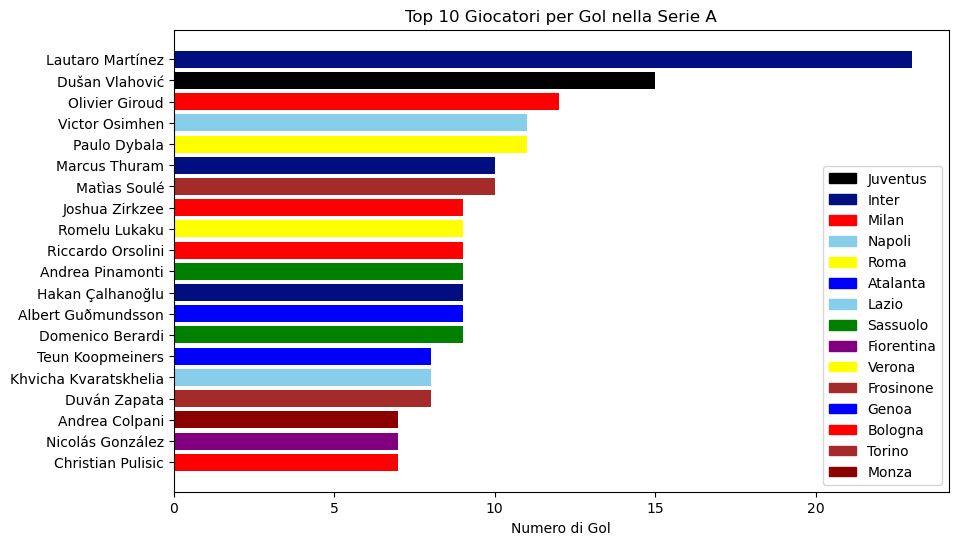

In [229]:
import matplotlib.pyplot as plt

# Definisci una mappatura di colori per ciascuna squadra
colors = {'Juventus': '#000000',    # Nero
          'Inter': '#010E80',       # Blu
          'Milan': '#FF0000',       # Rosso
          'Napoli': '#87CEEB',      # Celeste
          'Roma': '#FFFF00',        # Giallo
          'Atalanta': '#0000FF',    # Blu
          'Lazio': '#87CEEB',       # Celeste
          'Sassuolo': '#008000',    # Verde
          'Fiorentina': '#800080',  # Viola
          'Verona': '#FFFF00',      # Giallo
          'Frosinone': '#A52A2A',   # Marrone
          'Genoa': '#0000FF',       # Blu
          'Bologna': '#FF0000',     # Rosso
          'Torino': '#A52A2A',      # Marrone
          'Monza': '#8B0000'}       # Rosso scuro


# Ordina il DataFrame per il numero di gol
df_sorted = df.sort_values(by='(Performance, Gls)', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
bars = plt.barh(df_sorted['(Background Information, Full Name)'], df_sorted['(Performance, Gls)'], 
                color=[colors[squad] for squad in df_sorted['(Background Information, Squad)']])
plt.xlabel('Numero di Gol')
plt.title('Top 10 Giocatori per Gol nella Serie A')
plt.gca().invert_yaxis()

# Aggiungi legenda per le squadre
legend_colors = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
plt.legend(legend_colors, colors.keys())

plt.show()

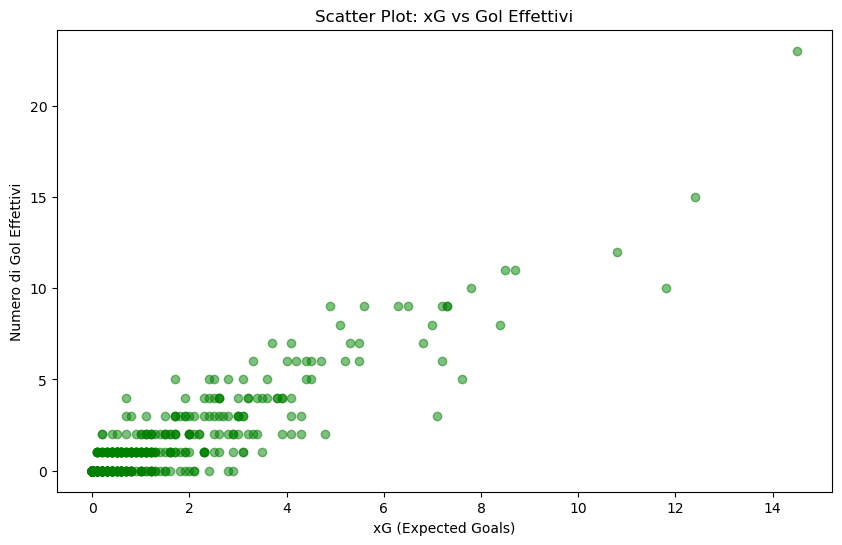

In [230]:
plt.figure(figsize=(10,6))
plt.scatter(df['(Expected, xG)'], df['(Performance, Gls)'], color='green', alpha=0.5)
plt.xlabel('xG (Expected Goals)')
plt.ylabel('Numero di Gol Effettivi')
plt.title('Scatter Plot: xG vs Gol Effettivi')
plt.show()


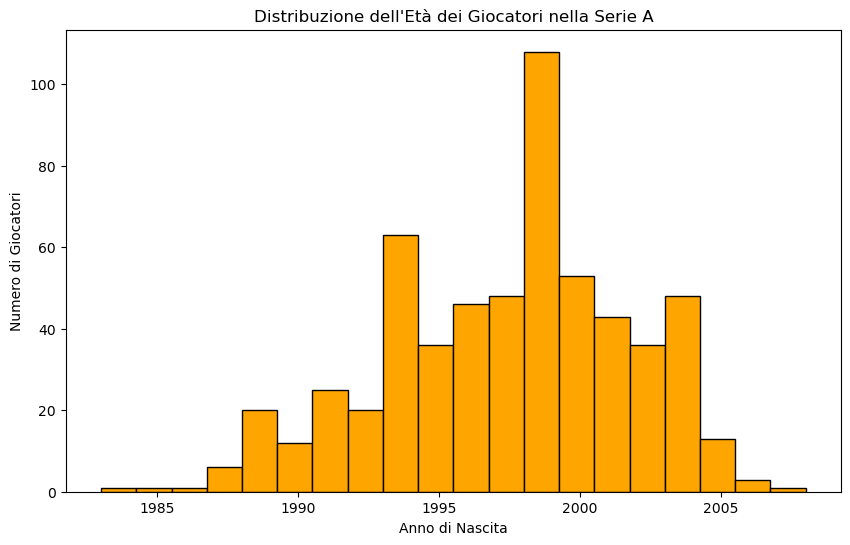

In [231]:
plt.figure(figsize=(10,6))
plt.hist(df['(Background Information, Year of Birth)'], bins=20, color='orange', edgecolor='black')
plt.xlabel('Anno di Nascita')
plt.ylabel('Numero di Giocatori')
plt.title('Distribuzione dell\'Età dei Giocatori nella Serie A')
plt.show()
